In [ ]:
# ============================================================================
# IMPORTS AND SETUP
# ============================================================================

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from PIL import Image
from model import UNet
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm import tqdm

# Set random seeds
from utils import (
    DiceBCELoss,
    train_epoch,
    validate_epoch,
    EarlyStopping
)

# Set random seeds
SEED = 1337
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

torch.backends.cudnn.benchmark = True


Using device: cuda


In [2]:
# ============================================================================\n
# CONFIGURATION (Updated for Task 2)
# ============================================================================\n
train_file = 'train.txt'
val_file = 'val.txt'

class Config:
    # Dataset paths
    DATASET_PATH = "data\\kvasir-seg"
    IMAGE_DIR = "images"
    MASK_DIR = "masks"
    
    # Experiment parameters
    # RESOLUTIONS = [512, 256, 128, 64] # <-- Removed/Commented out (Task 1 only)
    TARGET_SIZE = 256
    
    # Training parameters
    BATCH_SIZE = 8
    NUM_EPOCHS = 25
    LEARNING_RATE = 1e-4
    
    # Early stopping
    EARLY_STOPPING_PATIENCE = 5 
    # LR Scheduler
    SCHEDULER_PATIENCE = 3 
    SCHEDULER_FACTOR = 0.1 
    
    # Model parameters
    IN_CHANNELS = 3
    OUT_CHANNELS = 1
    FEATURES = [64, 128, 256, 512]
    
config = Config()

In [14]:
class KvasirDataset(Dataset):
    
    def __init__(self, image_paths, mask_paths, target_size=256, use_augmentations=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        
        # --- Define Augmentation Pipelines ---
        
        # Validation/Base pipeline (just resize)
        val_transform = [
            A.Resize(height=target_size, width=target_size, 
                     interpolation=cv2.INTER_LINEAR),
            ToTensorV2()
        ]
        
        if use_augmentations:
            # Training pipeline (resize + augs)
            self.transform = A.Compose([
                A.Resize(height=target_size, width=target_size, 
                         interpolation=cv2.INTER_LINEAR),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.Rotate(limit=30, interpolation=cv2.INTER_LINEAR, 
                         border_mode=cv2.BORDER_CONSTANT, p=0.5),
                A.ColorJitter(brightness=0.3, contrast=0.3, 
                              saturation=0.3, hue=0.1, p=0.5),
                ToTensorV2()
            ])
        else:
            # Validation pipeline
            self.transform = A.Compose(val_transform)

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # OPTIMIZED: Use cv2 instead of PIL - much faster!
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        
        # Binarize mask (0 or 1) *before* transforms
        mask = (mask > 128).astype(np.uint8)
        
        # Apply transforms
        augmented = self.transform(image=image, mask=mask)
        
        image_tensor = augmented['image']
        mask_tensor = augmented['mask']
        
        # Add channel dimension to mask (H, W) -> (1, H, W)
        # and convert from int64 to float for the loss function
        mask_tensor = mask_tensor.unsqueeze(0).float()
        
        return image_tensor, mask_tensor

In [3]:
# ============================================================================
# PATH COLLECTION AND VALIDATION
# ============================================================================

import os
from pathlib import Path

# Simple file existence check
if not os.path.exists('train.txt') or not os.path.exists('val.txt'):
    raise FileNotFoundError('train.txt or val.txt missing.')

base_path = Path(config.DATASET_PATH)
image_paths = sorted(list((base_path / config.IMAGE_DIR).glob('*.jpg')))
mask_paths = sorted(list((base_path / config.MASK_DIR).glob('*.jpg')))

if len(image_paths) != len(mask_paths):
    raise ValueError("Mismatch between number of images and masks.")

# Read train/val lists
with open('train.txt', 'r') as f:
    train_stems = {line.strip() for line in f}
with open('val.txt', 'r') as f:
    val_stems = {line.strip() for line in f}

# Split dataset according to txt files
train_images = [p for p in image_paths if p.stem in train_stems]
train_masks = [p for p in mask_paths if p.stem in train_stems]
val_images = [p for p in image_paths if p.stem in val_stems]
val_masks = [p for p in mask_paths if p.stem in val_stems]

print(f"Train: {len(train_images)} images, Val: {len(val_images)} images")


Train: 700 images, Val: 300 images


In [4]:
# ============================================================================
# MODEL CALL
# ============================================================================

def test_model_call():
    model = UNet(in_channels=3, out_channels=1).to(device)
    print("Model created successfully!")
    
    # Create a dummy input tensor
    dummy_input = torch.randn(1, 3, 256, 256).to(device)
    print(f"Input shape: {dummy_input.shape}")
    
    # Forward pass
    with torch.no_grad():
        output = model(dummy_input)
    print(f"Output shape: {output.shape}")

test_model_call()

Model created successfully!
Input shape: torch.Size([1, 3, 256, 256])
Output shape: torch.Size([1, 1, 256, 256])


# Configurations

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.double_conv(x)

# Dataset class Augmentation

In [17]:
class KvasirDataset(Dataset):
    """
    Dataset with Albumentations augmentation
    
    EXPERIMENT: Training uses augmentation, validation doesn't
    This tests if augmentation helps the model generalize better
    """
    
    def __init__(self, image_paths, mask_paths, target_size=256, use_augmentations=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths

        
        if use_augmentations:
            
            
            # TRAINING: WITH AUGMENTATION 
            
            self.transform = A.Compose([
                # Preprocessing (required)
                A.Resize(height=target_size, width=target_size, 
                         interpolation=cv2.INTER_LINEAR),
                
                # GEOMETRIC AUGMENTATIONS
                A.HorizontalFlip(p=0.5),        # Flip left-right
                A.VerticalFlip(p=0.5),          # Flip top-bottom
                A.Rotate(limit=30, interpolation=cv2.INTER_LINEAR, 
                         border_mode=cv2.BORDER_CONSTANT, p=0.5),  # Rotate
                
                # COLOR AUGMENTATIONS
                A.ColorJitter(brightness=0.3, contrast=0.3, 
                              saturation=0.3, hue=0.1, p=0.5),  # Change colors

                #  NORMALIZATION 
                A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
                
                # Convert to tensor
                ToTensorV2()
            ])
            print("Training augmentation enabled (4 techniques)")
            
        else:
            # VALIDATION: NO AUGMENTATION (BASELINE)
           self.transform = A.Compose([
                A.Resize(height=target_size, width=target_size, 
                         interpolation=cv2.INTER_LINEAR),
                A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),         
                ToTensorV2()
            ])
        print("Validation: no augmentation")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image and mask
        image = np.array(Image.open(self.image_paths[idx]).convert('RGB'))
        mask = np.array(Image.open(self.mask_paths[idx]).convert('L'))
        
        # Binarize mask (0 or 1)
        mask = (mask > 128).astype(np.uint8)
        
        # Apply augmentation (same transforms to both image and mask!)
        augmented = self.transform(image=image, mask=mask)
        image_tensor = augmented['image']
        mask_tensor = augmented['mask']
        
        # Add channel dimension to mask
        mask_tensor = mask_tensor.unsqueeze(0).float()
        
        return image_tensor, mask_tensor

print("Dataset class defined")

Dataset class defined


# Load dataset paths

In [18]:
# Check files exist
if not os.path.exists('train.txt') or not os.path.exists('val.txt'):
    raise FileNotFoundError('train.txt or val.txt missing!')

# Get all image and mask paths
base_path = Path(config.DATASET_PATH)
image_paths = sorted(list((base_path / config.IMAGE_DIR).glob('*.jpg')))
mask_paths = sorted(list((base_path / config.MASK_DIR).glob('*.jpg')))

if len(image_paths) != len(mask_paths):
    raise ValueError("Mismatch between images and masks!")

print(f"Found {len(image_paths)} images")

# Read train/val split
with open('train.txt', 'r') as f:
    train_stems = {line.strip() for line in f}
with open('val.txt', 'r') as f:
    val_stems = {line.strip() for line in f}

# Split dataset
train_images = [p for p in image_paths if p.stem in train_stems]
train_masks = [p for p in mask_paths if p.stem in train_stems]
val_images = [p for p in image_paths if p.stem in val_stems]
val_masks = [p for p in mask_paths if p.stem in val_stems]

# Print split info
print(f"Training:   {len(train_images)} images ({len(train_images)/(len(train_images)+len(val_images))*100:.1f}%)")
print(f"Validation: {len(val_images)} images ({len(val_images)/(len(train_images)+len(val_images))*100:.1f}%)")



Found 1000 images
Training:   700 images (70.0%)
Validation: 300 images (30.0%)


# Create dataloaders

In [19]:
print("\nCreating datasets...")

# Training dataset WITH AUGMENTATION
train_dataset = KvasirDataset(
    train_images, 
    train_masks, 
    target_size=config.TARGET_SIZE,
    use_augmentations=True  # ← THE KEY! This enables augmentation
)

# Validation dataset WITHOUT AUGMENTATION
val_dataset = KvasirDataset(
    val_images, 
    val_masks, 
    target_size=config.TARGET_SIZE,
    use_augmentations=False  # ← No augmentation for validation
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")


Creating datasets...
Training augmentation enabled (4 techniques)
Validation: no augmentation
Validation: no augmentation
Training batches: 88
Validation batches: 38


# Metrics and loss functions

In [9]:
def dice_coefficient(pred, target, smooth=1e-6):
    """
    Dice Coefficient - measures overlap (0-1, higher is better)
    Main metric for segmentation tasks
    """
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice.mean()


def iou_score(pred, target, smooth=1e-6):
    """
    IoU (Intersection over Union) - alternative overlap metric (0-1, higher is better)
    """
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()


class DiceBCELoss(nn.Module):
    """
    Combined Dice + BCE Loss
    Best for segmentation - handles class imbalance well
    """
    def __init__(self, weight_dice=0.5, weight_bce=0.5):
        super().__init__()
        self.weight_dice = weight_dice
        self.weight_bce = weight_bce
        self.bce = nn.BCEWithLogitsLoss()
    
    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        
        pred_sigmoid = torch.sigmoid(pred)
        smooth = 1e-6
        intersection = (pred_sigmoid * target).sum(dim=(2, 3))
        union = pred_sigmoid.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
        dice_loss = 1 - (2.0 * intersection + smooth) / (union + smooth)
        dice_loss = dice_loss.mean()
        
        return self.weight_bce * bce_loss + self.weight_dice * dice_loss

print("Metrics and loss functions defined")


Metrics and loss functions defined


# Training and validation functions

In [12]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()  # Set model to training mode
    total_loss = 0
    total_dice = 0
    total_iou = 0
    
    
    for batch_idx, (images, masks) in enumerate(dataloader):
        # Move data to GPU/CPU
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)  # Get predictions
        
        # Calculate loss
        loss = criterion(outputs, masks)
        
        # Backward pass
        loss.backward()  # Calculate gradients
        optimizer.step()  # Update weights
        
        # Track metrics
        total_loss += loss.item()
        total_dice += dice_coefficient(outputs, masks).item()
        total_iou += iou_score(outputs, masks).item()
        
    
    # Return average metrics
    return (total_loss / len(dataloader), 
            total_dice / len(dataloader), 
            total_iou / len(dataloader))


def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch"""
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    total_dice = 0
    total_iou = 0
    
    with torch.no_grad():  # Don't calculate gradients (saves memory)
        for batch_idx, (images, masks) in enumerate(dataloader):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            total_loss += loss.item()
            total_dice += dice_coefficient(outputs, masks).item()
            total_iou += iou_score(outputs, masks).item()
            
    
    return (total_loss / len(dataloader), 
            total_dice / len(dataloader), 
            total_iou / len(dataloader))

print("Training and validation functions defined")


Training and validation functions defined


# MAIN TRAINING LOOP (WITH LR SCHEDULING + EARLY STOPPING)

In [13]:

# Initialize model
model = UNet(in_channels=config.IN_CHANNELS, 
                 out_channels=config.OUT_CHANNELS).to(device)

# Loss function
criterion = DiceBCELoss(weight_dice=0.5, weight_bce=0.5)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=1e-5)

#  LEARNING RATE SCHEDULER (REQUIRED!)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max',  # Maximize Dice score
    factor=config.SCHEDULER_FACTOR,  # Reduce by 90%
    patience=config.SCHEDULER_PATIENCE,  # Wait 3 epochs
    verbose=True  # Print when LR changes
)

# Training history
history = {
    'train_loss': [],
    'train_dice': [],
    'train_iou': [],
    'val_loss': [],
    'val_dice': [],
    'val_iou': [],
    'lr': []
}

#  EARLY STOPPING (REQUIRED!)
best_dice = 0
patience_counter = 0

print("=" * 70)
print("STARTING TRAINING WITH DATA AUGMENTATION")
print("=" * 70)
print(f"Image size: {config.TARGET_SIZE}x{config.TARGET_SIZE}")
print(f"Batch size: {config.BATCH_SIZE}")
print(f"Learning rate: {config.LEARNING_RATE}")
print(f"Max epochs: {config.NUM_EPOCHS}")
print("=" * 70)

# Training loop
verbose = True

for epoch in range(config.NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{config.NUM_EPOCHS}")
    print("-" * 70)
    
    # Training phase
    train_loss, train_dice, train_iou = train_epoch(
        model, train_loader, criterion, optimizer, device
    )
    
    # Validation phase
    val_loss, val_dice, val_iou = validate_epoch(
        model, val_loader, criterion, device
    )

    #  UPDATE LEARNING RATE (REQUIRED!)
    scheduler.step(val_dice)  # Reduce LR if Dice doesn't improve
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_dice'].append(train_dice)
    history['train_iou'].append(train_iou)
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_dice)
    history['val_iou'].append(val_iou)
    history['lr'].append(current_lr)
    
    # Print metrics
    if verbose and (epoch + 1) % 5 == 0:
         # Cleaner output every 5 epochs
        print(f'Epoch [{epoch+1}/{config.NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}')
    elif not verbose:
        # Detailed output every epoch
        print(f"\nTrain - Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}")
        print(f"Learning Rate: {current_lr:.6f}")
         
    
    # EARLY STOPPING LOGIC (REQUIRED!)
    if val_dice > best_dice:
        # Validation improved!
        best_dice = val_dice
        patience_counter = 0  # Reset counter
        
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_dice': val_dice,
            'val_iou': val_iou,
        }, 'best_model_augmented.pth')
        print(f"SAVED best model (Dice: {val_dice:.4f})")
    else:
        # No improvement
        patience_counter += 1
        if not verbose or (epoch + 1) % 5 == 0:
            print(f"  No improvement ({patience_counter}/{config.EARLY_STOPPING_PATIENCE})")
    
    # CHECK EARLY STOPPING (REQUIRED!)
    if patience_counter >= config.EARLY_STOPPING_PATIENCE:
        print(f"\nEARLY STOPPING triggered after {epoch+1} epochs")
        print(f"  No improvement for {config.EARLY_STOPPING_PATIENCE} epochs")
        break

print("\n" + "=" * 70)
print(f"TRAINING COMPLETE! Best Dice: {best_dice:.4f}")
print("=" * 70)

STARTING TRAINING WITH DATA AUGMENTATION
Image size: 256x256
Batch size: 8
Learning rate: 0.0001
Max epochs: 25

Epoch 1/25
----------------------------------------------------------------------
SAVED best model (Dice: 0.3385)

Epoch 2/25
----------------------------------------------------------------------
SAVED best model (Dice: 0.4174)

Epoch 3/25
----------------------------------------------------------------------
SAVED best model (Dice: 0.4703)

Epoch 4/25
----------------------------------------------------------------------

Epoch 5/25
----------------------------------------------------------------------
Epoch [5/25], Train Loss: 0.4910, Val Loss: 0.4869, Val Dice: 0.4968
SAVED best model (Dice: 0.4968)

Epoch 6/25
----------------------------------------------------------------------
SAVED best model (Dice: 0.5099)

Epoch 7/25
----------------------------------------------------------------------
SAVED best model (Dice: 0.5229)

Epoch 8/25
----------------------------------

KeyboardInterrupt: 

# Plot results

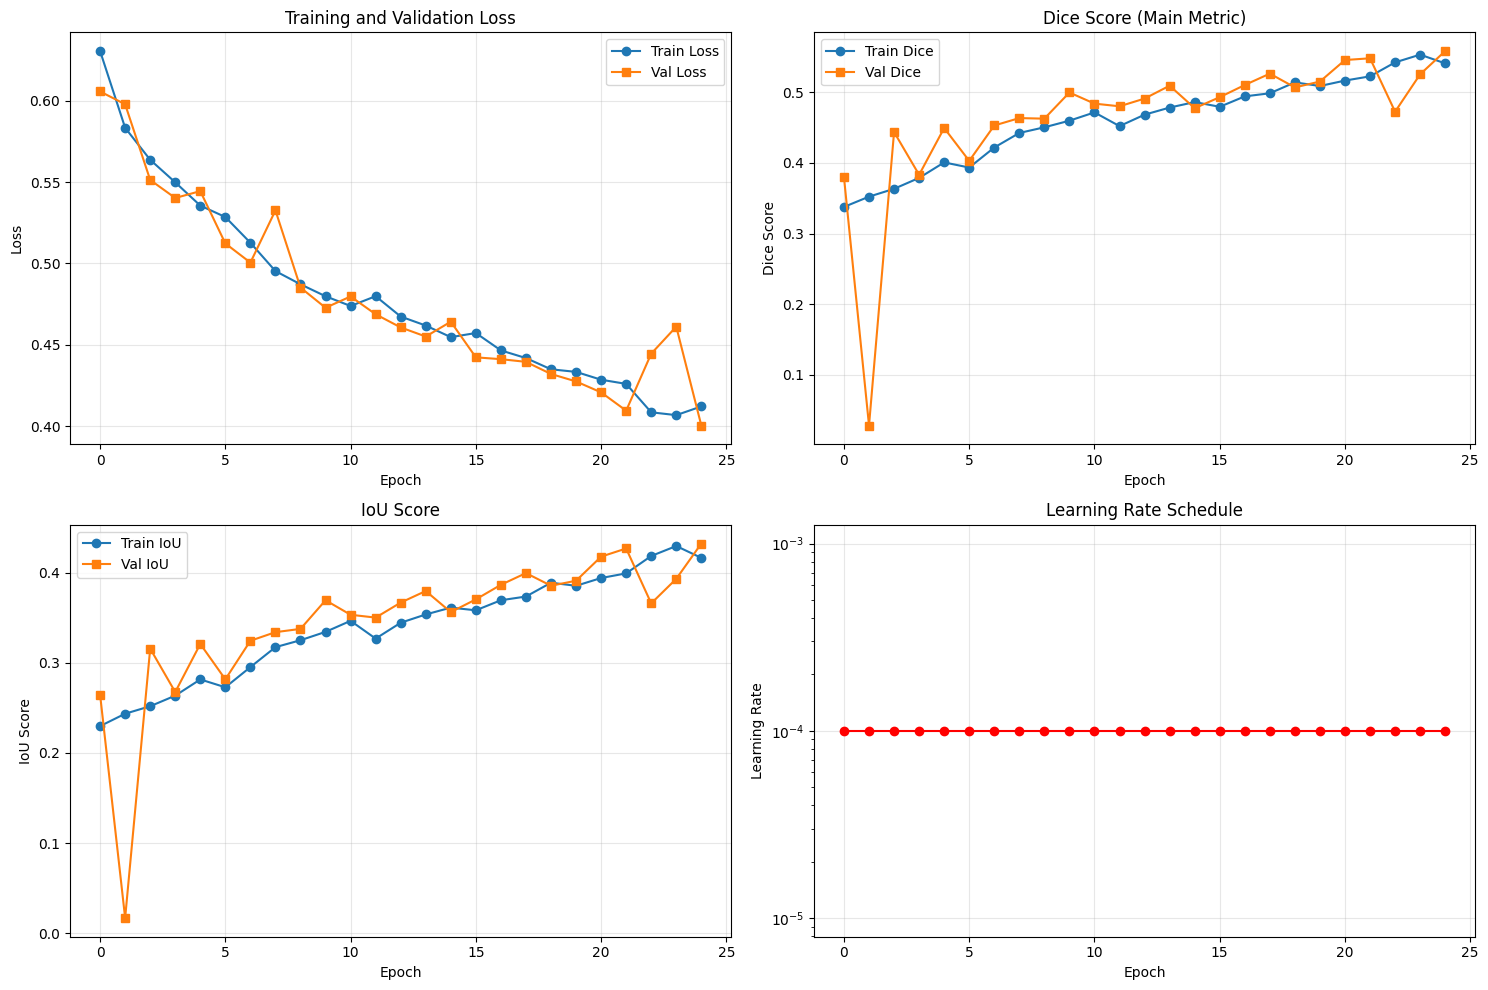

Plots saved as 'training_results_augmented.png'


In [35]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss plot
axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Dice plot
axes[0, 1].plot(history['train_dice'], label='Train Dice', marker='o')
axes[0, 1].plot(history['val_dice'], label='Val Dice', marker='s')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Dice Score')
axes[0, 1].set_title('Dice Score (Main Metric)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# IoU plot
axes[1, 0].plot(history['train_iou'], label='Train IoU', marker='o')
axes[1, 0].plot(history['val_iou'], label='Val IoU', marker='s')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('IoU Score')
axes[1, 0].set_title('IoU Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Learning rate plot
axes[1, 1].plot(history['lr'], marker='o', color='red')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_title('Learning Rate Schedule')
axes[1, 1].set_yscale('log')  # Log scale to see reductions clearly
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_results_augmented.png', dpi=150, bbox_inches='tight')
plt.show()

print("Plots saved as 'training_results_augmented.png'")

# Save results (aner ikke om dette trengs)

In [ ]:
# Save training history to CSV
history_df = pd.DataFrame(history)
history_df.to_csv('training_history_augmented.csv', index=False)
print("History saved as 'training_history_augmented.csv'")

print("\n" + "=" * 70)
print("ALL RESULTS SAVED!")
print("=" * 70)
print("\nGenerated files:")
print("  1. best_model_augmented.pth          - Best model checkpoint")
print("  2. training_history_augmented.csv    - All metrics per epoch")
print("  3. training_results_augmented.png    - Training curves")
print("=" * 70)
print("\nTASK 2 COMPLETE!")
print("Your experiment: Training WITH augmentation (8 techniques)")
print("Focus of report: How augmentation improves generalization")
print("=" * 70)
